In [1]:
import pandas as pd
import numpy as np
import re
import random

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
data_location = 'https://github.com/DHDSDesafios/DH_DS_desafio_2_properati/raw/master/data/properatid2caba.zip'
data = pd.read_csv(data_location, compression='zip', encoding="utf-8")

In [5]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero'],
      dtype='object')

In [6]:
data.shape

(29380, 36)

datosCol(serie) - Funcion que retorna diccionario con los datos de una Serie / Columna del DataFrame a analizar:

Campos:
 - nombre columna.
 - tipo de dato Pandas serie.
 - cantidad de registros en la serie.
 - cantidad de nulos en la serie.
 - cantidad de NO nulos en la serie.
 - porcentaje de No nulos en la serie.
 - cantidad de valores unicos en la serie.
 - valor mas repetido en la serie.
 - valor maximo en la serie.
 - valor minimos en la serie.
 - media, mediana y desvio estandar en la serie.
 - distribucion de cuantiles.
 - tipos de datos sobre los valores incluidos en la serie.

In [7]:
def datosCol(col=None):
    try:
        if col.dtype != object:
            return {
                    'nombre': col.name,
                    'series_dt': col.dtype,
                    'nulos': int(len(col) - col.describe()[0]), 
                    'nulos_porcentaje': round(col.isnull().sum() / col.size*100, 2),
                    'unicos': int(len(col.value_counts())),
                    'mas_repetido': col.value_counts().index[0],
                    'minimo': round(col.min(), 2),
                    'maximo': round(col.max(), 2),
                    'media': round(col.describe()[1], 2),
                    'mediana': col.median(),
                    'desvio': round(col.describe()[2], 2),
                    'q25': col.describe()[4],
                    'q50': col.describe()[5],
                    'q75': col.describe()[6],
                    'values_dt': [x for x in col.apply(lambda x: type(x)).value_counts().index]
                   }
        else:
            return {
                    'nombre': col.name,
                    'series_dt': col.dtype,
                    'nulos': col.isnull().sum(),
                    'nulos_porcentaje': round(col.isnull().sum() / col.size*100, 2),
                    'unicos': int(col.describe()[1]), 
                    'mas_repetido': col.describe()[2],
                    'nulos': col.isnull().sum(),
                    'frecuencia': int(col.describe()[3]),
                    'values_dt': [x for x in col.apply(lambda x: type(x)).value_counts().index]
                   }
    except:
        return 'use a valid pandas Series'

In [8]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero'],
      dtype='object')

In [9]:
data_info = pd.DataFrame([datosCol(data[x]) for x in ['property_type', 'place_name', 'price_aprox_usd', 'floor', 'rooms',
                                                      'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
                                                      'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
                                                      'balcon', 'terraza', 'jardin', 'lavadero'] ])
data_info

,nombre,series_dt,nulos,nulos_porcentaje,unicos,mas_repetido,frecuencia,values_dt,minimo,maximo,media,mediana,desvio,q25,q50,q75
0,property_type,object,0,0.00,4,apartment,24713.0,[<class 'str'>],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,place_name,object,0,0.00,62,Belgrano,2745.0,[<class 'str'>],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,price_aprox_usd,float64,1532,5.21,5237,120000,NaN,[<class 'float'>],5103.61,46545445.00,263567.97,155000.00,452774.30,104724.465,155000.00,278000.00
3,floor,float64,26480,90.13,82,1,NaN,[<class 'float'>],1.00,2509.00,12.64,4.00,83.22,2.000,4.00,7.00
4,rooms,float64,11341,38.60,17,2,NaN,[<class 'float'>],1.00,22.00,2.55,2.00,1.47,1.000,2.00,3.00
5,price_usd_per_m2,float64,7227,24.60,10452,2500,NaN,[<class 'float'>],13.80,206333.33,3146.57,2486.41,3722.99,1988.950,2486.41,3094.27
6,price_per_m2,float64,2512,8.55,12115,2500,NaN,[<class 'float'>],3.21,2600000.00,3839.77,2727.27,18864.14,2177.420,2727.27,3440.00
7,surface_total_in_m2,float64,3638,12.38,734,40,NaN,[<class 'float'>],0.00,200000.00,116.88,62.00,1268.88,42.000,62.00,110.00
8,surface_covered_in_m2,float64,1170,3.98,620,30,NaN,[<class 'float'>],0.00,10958.00,91.43,55.00,203.58,38.000,55.00,95.00
9,cochera,float64,19299,65.69,1,1,NaN,[<class 'float'>],1.00,1.00,1.00,1.00,0.00,1.000,1.00,1.00


In [10]:
data.surface_total_in_m2 == 200000.00
data.loc[data.surface_total_in_m2 == 200000.00, :]

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,surface_total_in_m2,surface_covered_in_m2,cochera,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero
5196,24548,apartment,|Argentina|Capital Federal|San Telmo|,Argentina,Capital Federal,"-34.6213421,-58.3741846",-34.621342,-58.374185,46545445.0,USD,...,200000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.loc[data.cochera.isnull(), 'cochera'] = 0
data.cochera.astype('uint8')

data.loc[data.piscina.isnull(), 'piscina'] = 0
data.piscina.astype('uint8')

data.loc[data.lavadero.isnull(), 'lavadero'] = 0
data.lavadero.astype('uint8')

data.loc[data.parrilla.isnull(), 'parrilla'] = 0
data.parrilla.astype('uint8')

data.loc[data.terraza.isnull(), 'terraza'] = 0
data.terraza.astype('uint8')

data.loc[data.jardin.isnull(), 'jardin'] = 0
data.jardin.astype('uint8')

data.loc[data.balcon == 'Balcon', 'balcon'] = 1
data.loc[data.balcon == 'BALCON', 'balcon'] = 1
data.loc[data.balcon == 'balcon', 'balcon'] = 1
data.loc[data.balcon.notnull(), 'balcon'] = 1
data.loc[data.balcon.isnull(), 'balcon'] = 0
data.balcon.astype('uint8')

data.loc[data.baulera.isnull(), 'baulera'] = 0
data.baulera.astype('uint8')

0        0
1        0
2        0
3        0
4        0
        ..
29375    0
29376    0
29377    1
29378    0
29379    0
Name: baulera, Length: 29380, dtype: uint8

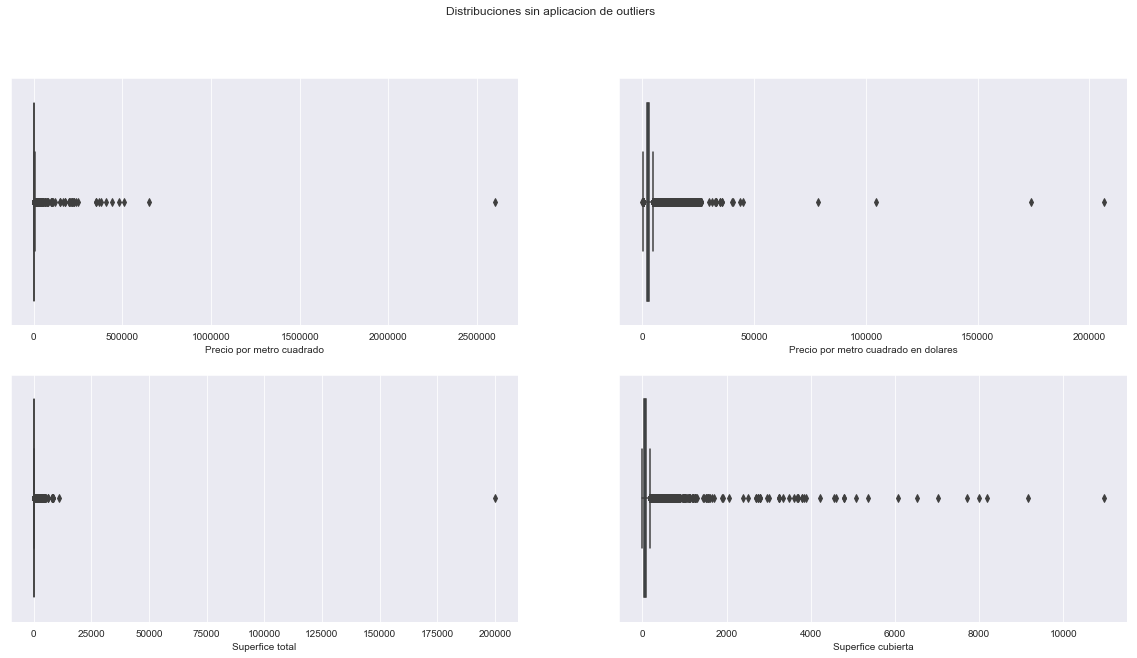

In [12]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(2,2,figsize=(20,10))
fig.suptitle('Distribuciones sin aplicacion de outliers')

sns.boxplot(x='price_per_m2', data=data, ax=axs[0,0])
axs[0,0].set(xlabel='Precio por metro cuadrado') 

sns.boxplot(x='price_usd_per_m2', data=data, ax=axs[0,1])
axs[0,1].set(xlabel='Precio por metro cuadrado en dolares')

sns.boxplot(x='surface_total_in_m2', data=data, ax=axs[1,0])
axs[1,0].set(xlabel='Superfice total')

sns.boxplot(x='surface_covered_in_m2', data=data, ax=axs[1,1])
axs[1,1].set(xlabel='Superfice cubierta')

plt.show()

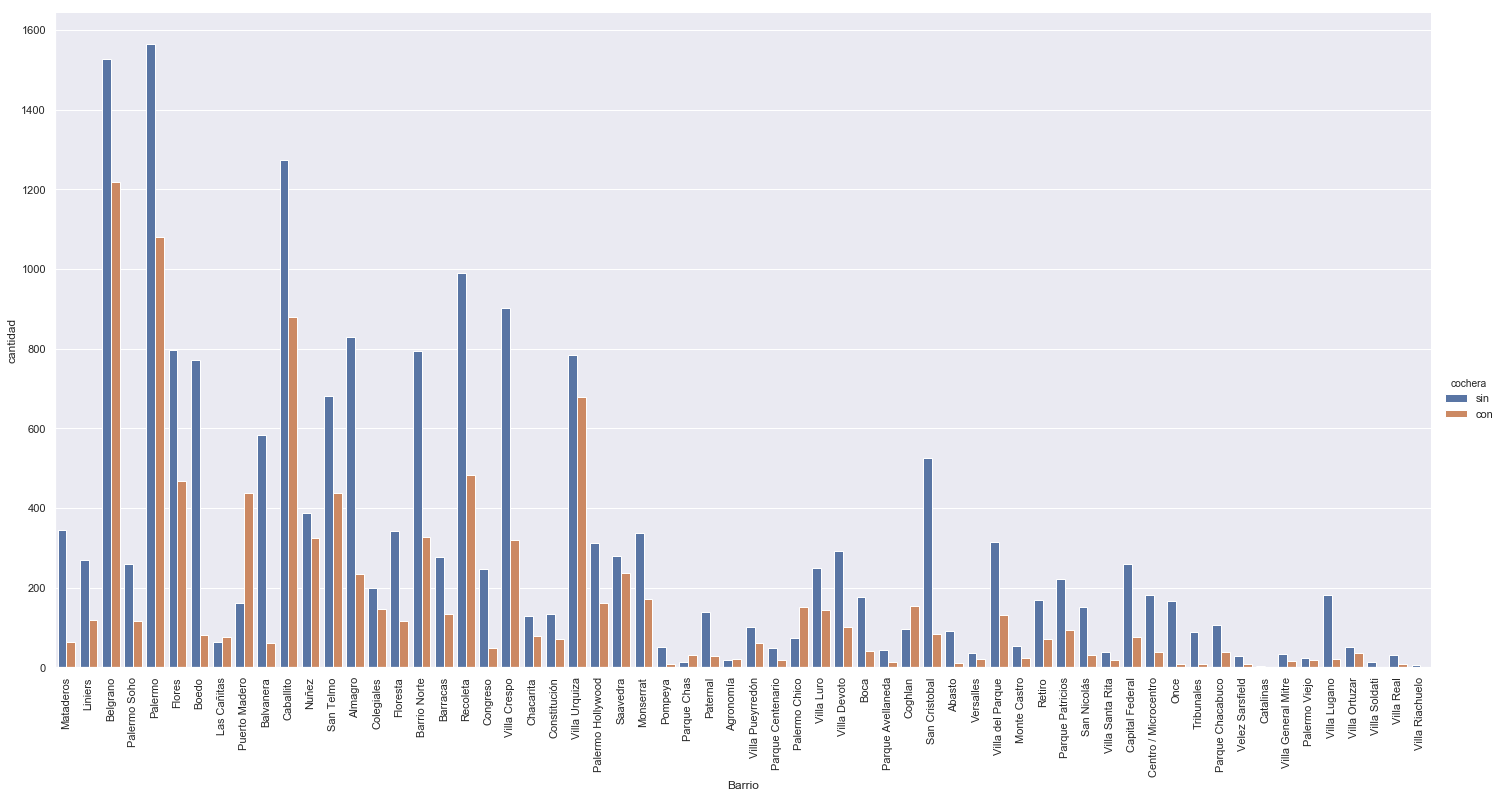

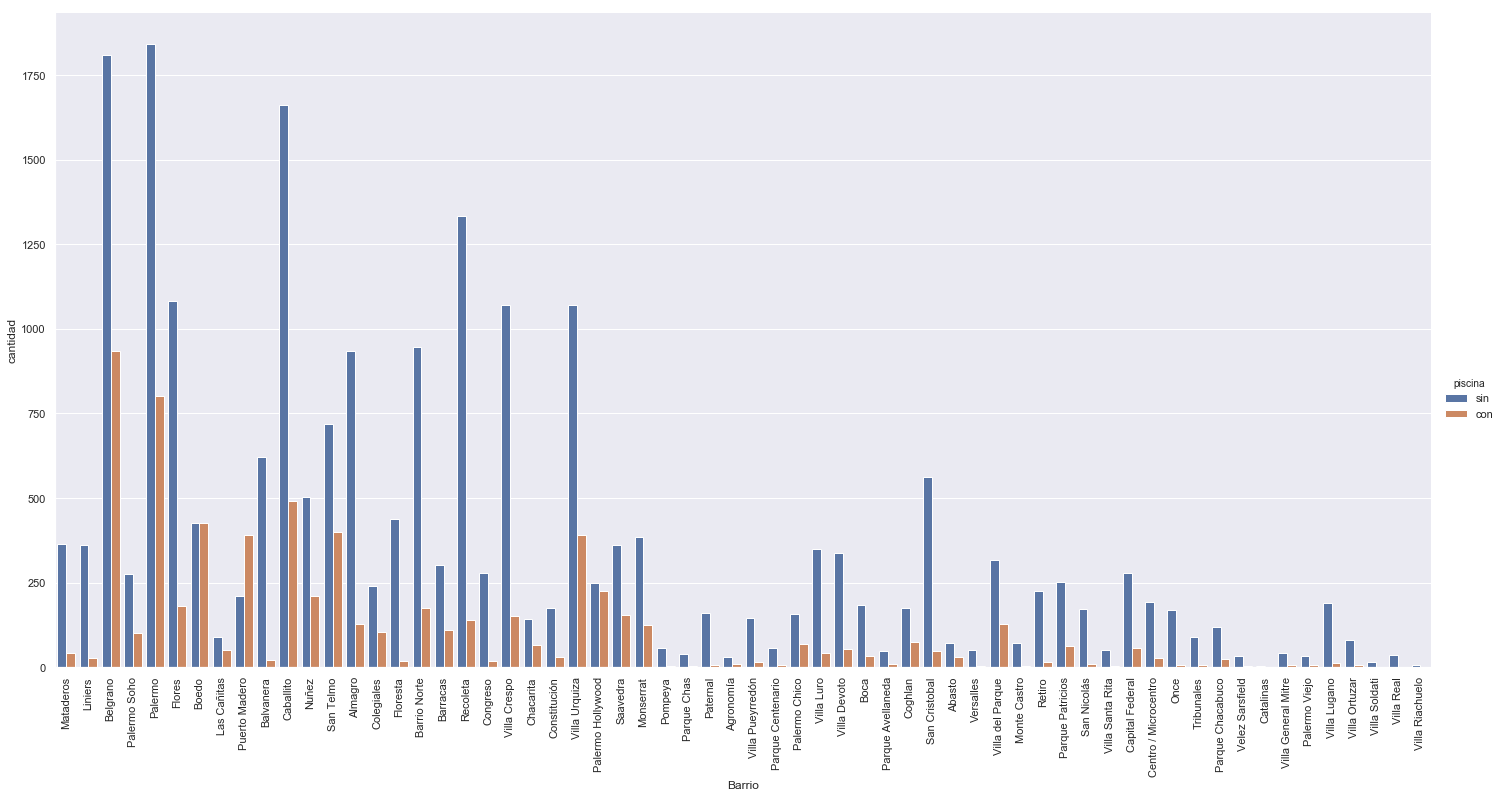

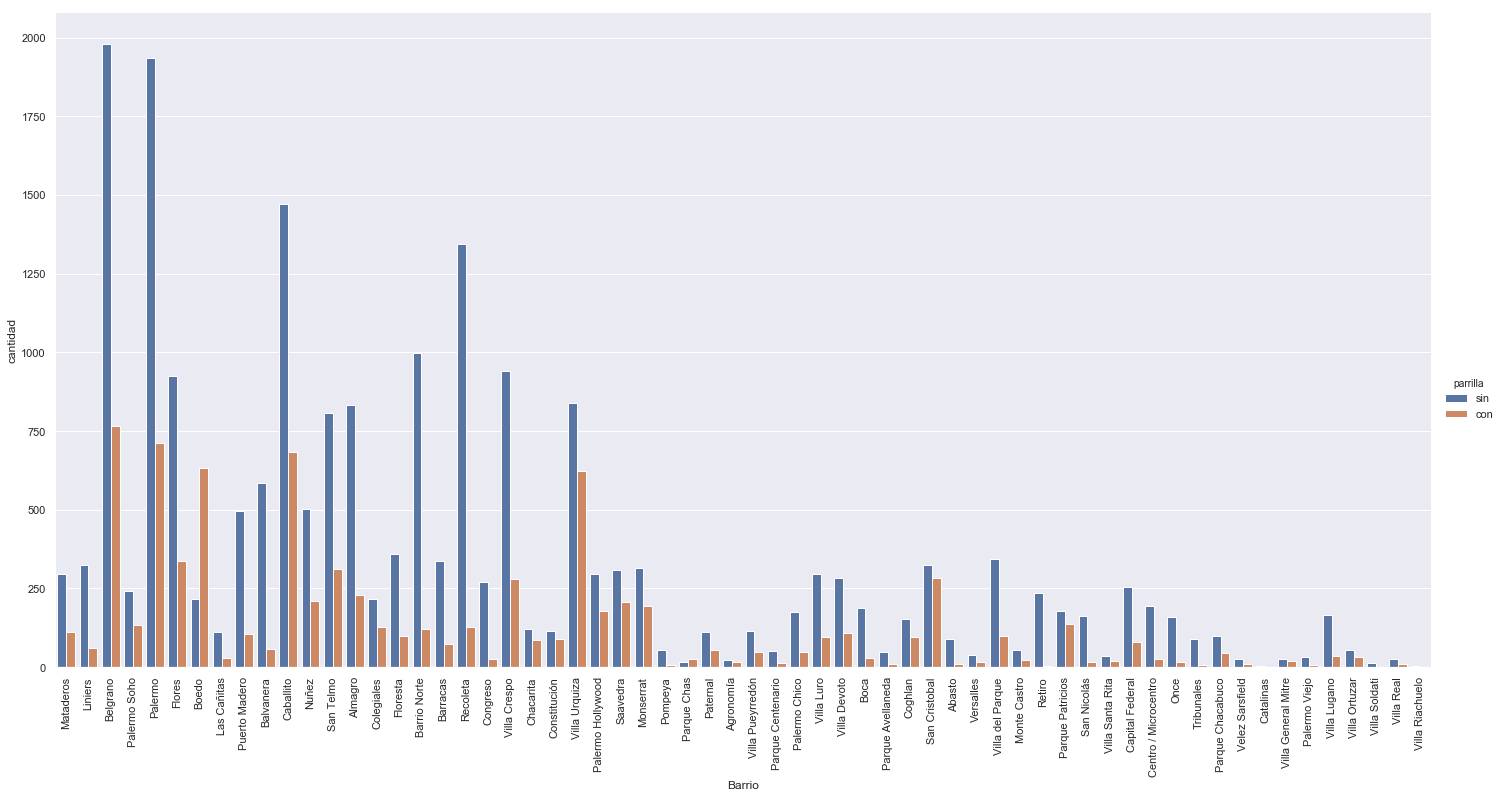

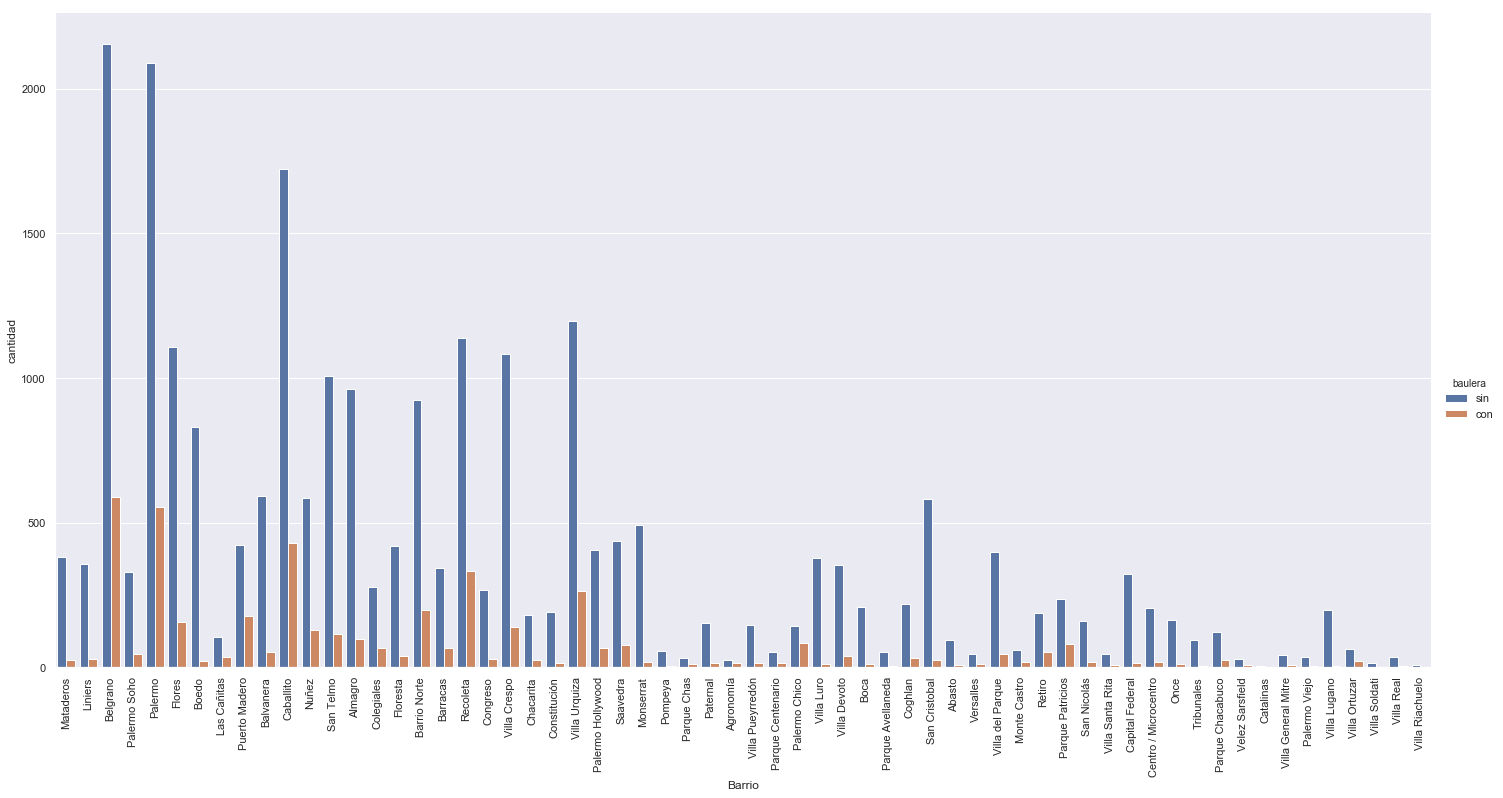

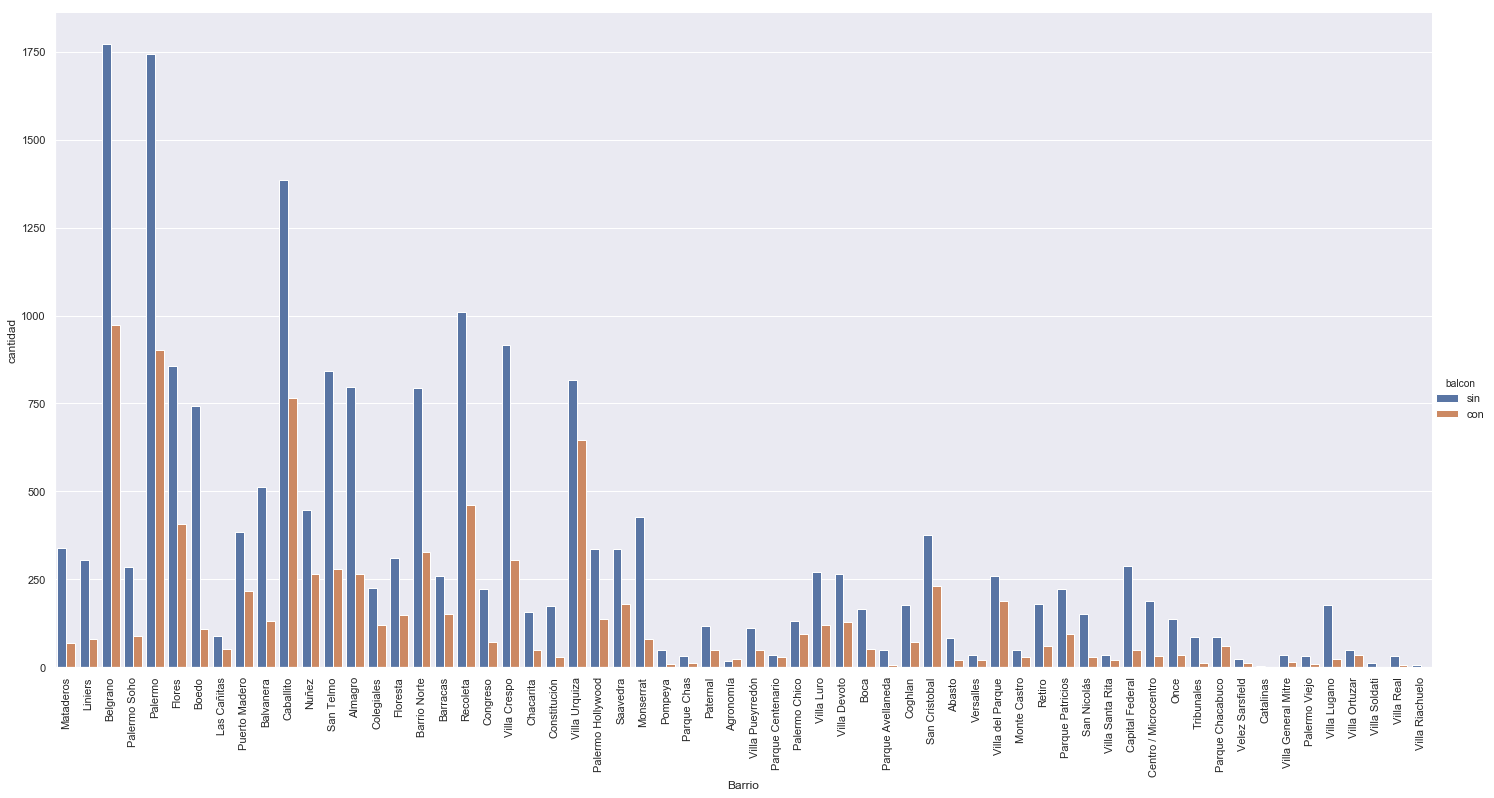

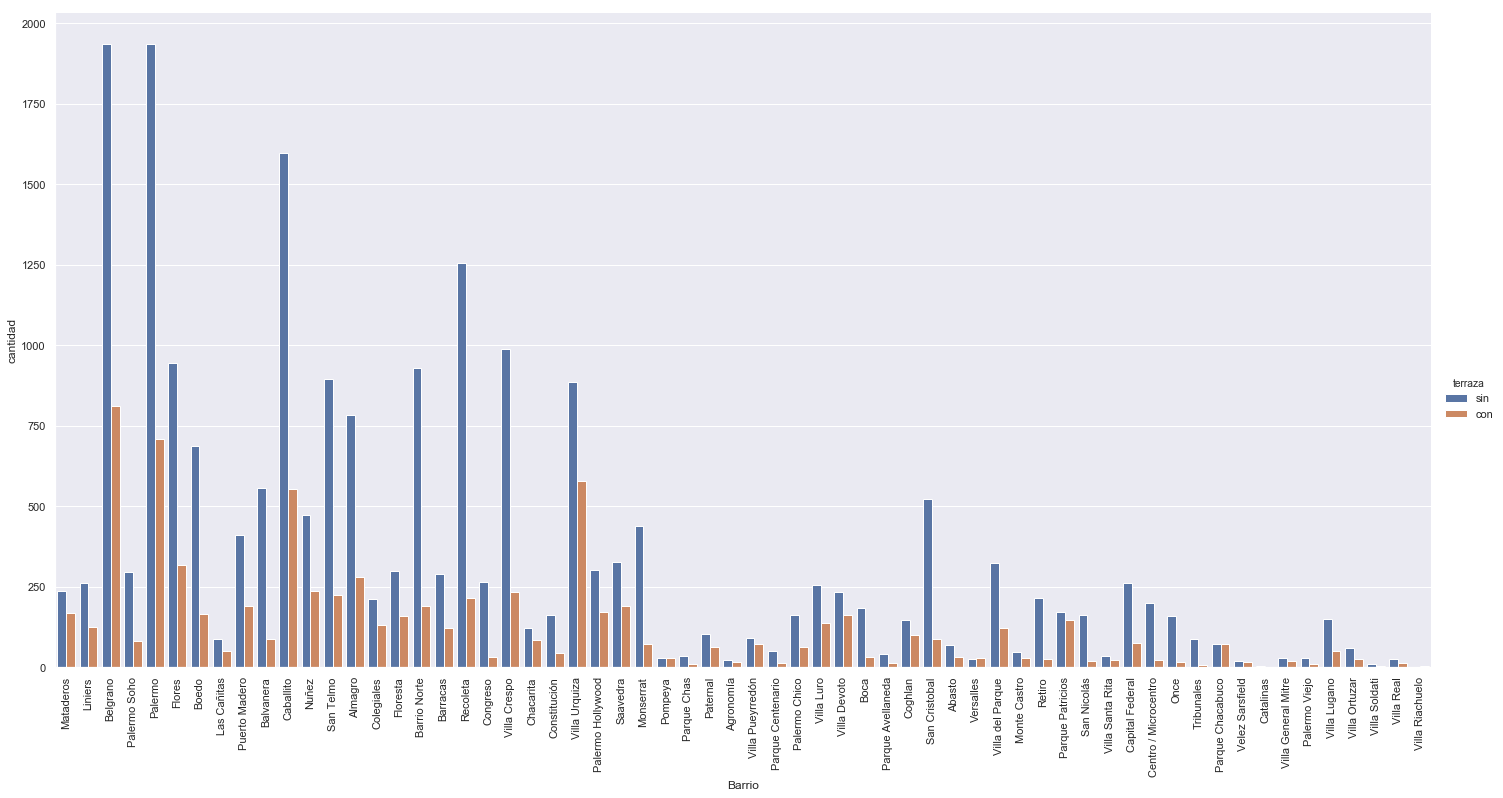

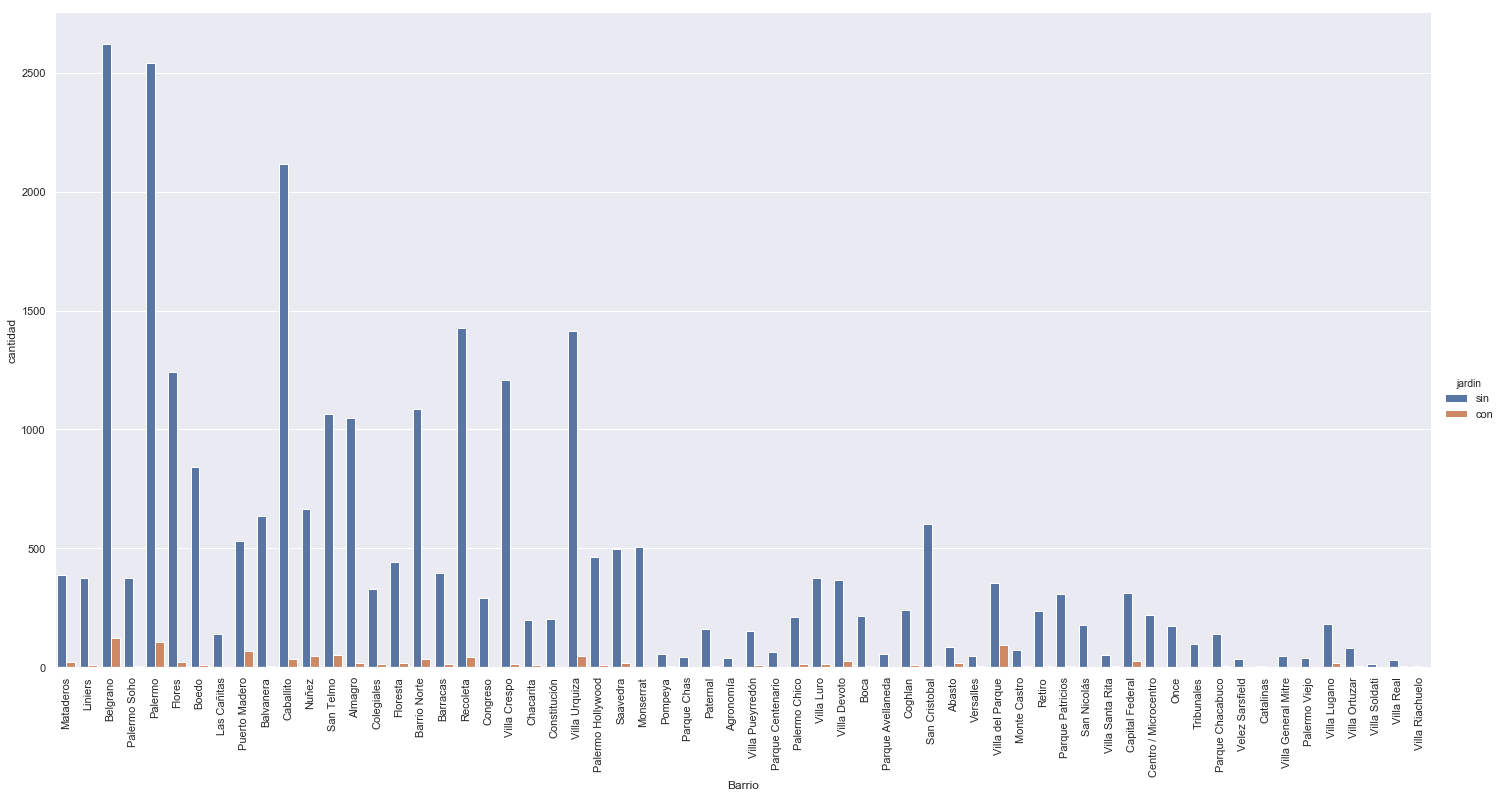

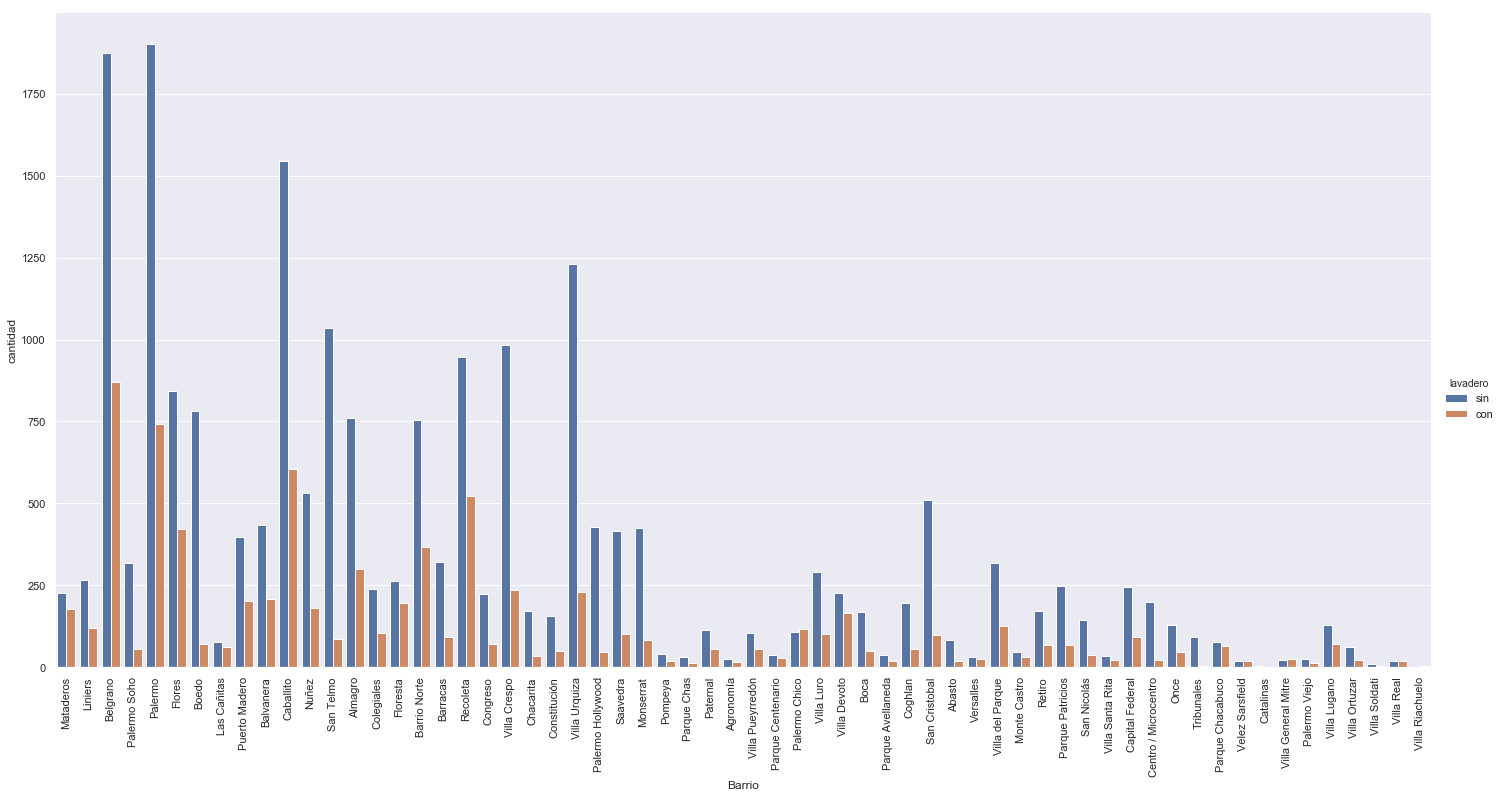

In [177]:
for x in data.columns[28:]:
    g = sns.catplot(x='place_name', hue=x, kind='count', data=data, height=10, aspect=2, legend_out=True)
    g.set_xticklabels(rotation=90)
    g.set(xlabel='Barrio', ylabel='cantidad')
    g._legend.set_title(x)
    new_labels = ['sin', 'con']
    for t, l in zip(g._legend.texts, new_labels): 
        t.set_text(l)

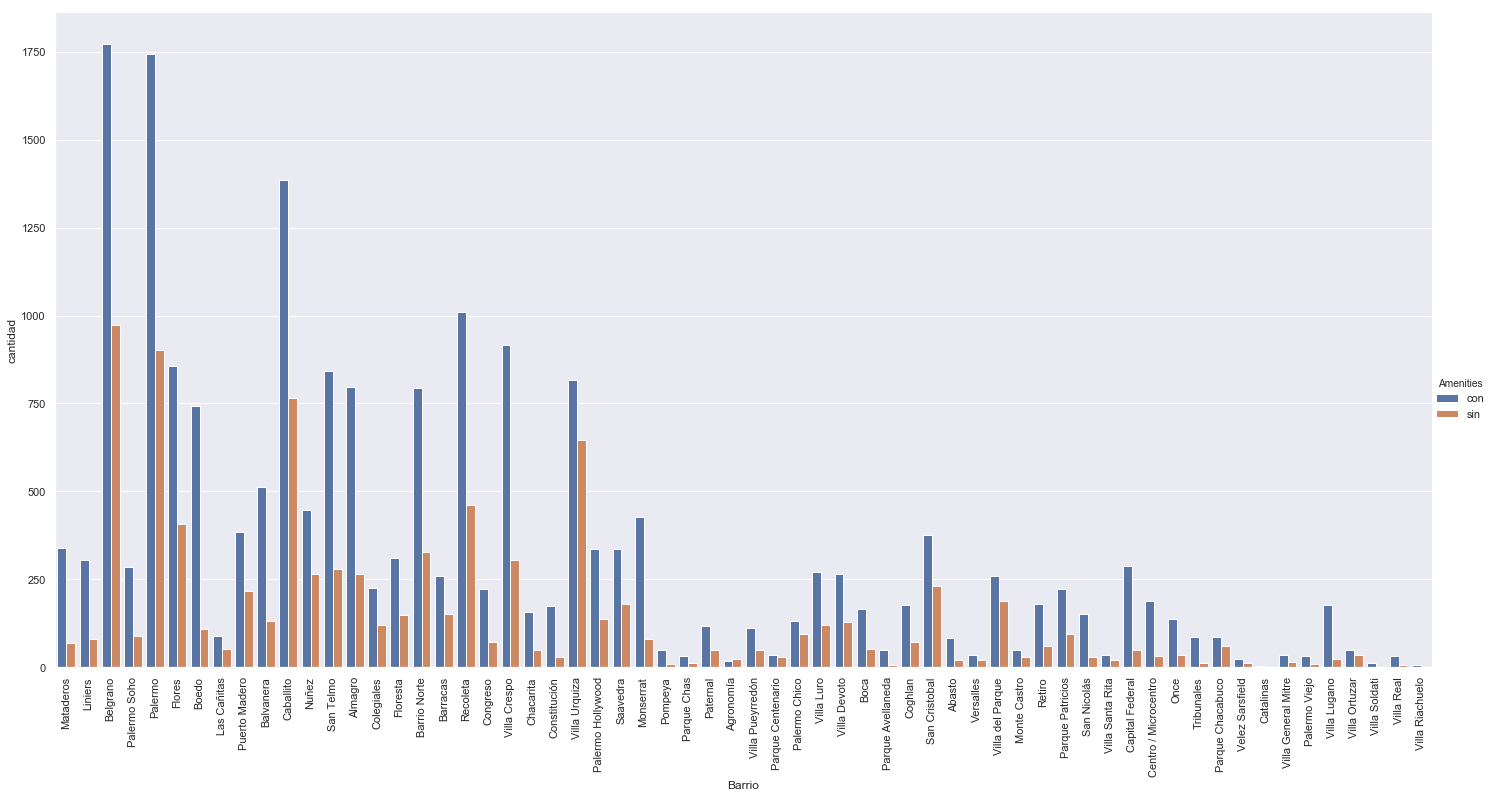

In [163]:

g1 = sns.catplot(x='place_name', hue='balcon', kind='count', data=data, height=10, aspect=2, legend_out=True)
#g2 = sns.catplot(x='place_name', hue='terraza', kind='count', data=data,height=10, aspect=2, legend_out=True)
g1.set_xticklabels(rotation=90)
#g2.set_xticklabels(rotation=90)
g1.set(xlabel='Barrio', ylabel='cantidad')
#g2.set(xlabel='Barrio', ylabel='cantidad')

# title
new_title = 'Amenities'
g1._legend.set_title(new_title)
# replace labels
new_labels = ['con', 'sin']
for t, l in zip(g1._legend.texts, new_labels): t.set_text(l)


In [3]:
data.sample(3)

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,surface_total_in_m2,surface_covered_in_m2,cochera,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero
22562,89326,apartment,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,NaN,NaN,NaN,179101.0,USD,...,51.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27440,113989,apartment,|Argentina|Capital Federal|Recoleta|,Argentina,Capital Federal,"-34.5895459,-58.3973636",-34.589546,-58.397364,498000.0,USD,...,250.0,243.0,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0
4937,23218,apartment,|Argentina|Capital Federal|Las Cañitas|,Argentina,Capital Federal,"-34.5726409,-58.4323654",-34.572641,-58.432365,498000.0,USD,...,181.0,171.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data.loc[data.cochera.isnull(), 'cochera'] = 0
data.cochera.astype('uint8')

data.loc[data.piscina.isnull(), 'piscina'] = 0
data.piscina.astype('uint8')

data.loc[data.lavadero.isnull(), 'lavadero'] = 0
data.lavadero.astype('uint8')

data.loc[data.parrilla.isnull(), 'parrilla'] = 0
data.parrilla.astype('uint8')

data.loc[data.terraza.isnull(), 'terraza'] = 0
data.terraza.astype('uint8')

data.loc[data.jardin.isnull(), 'jardin'] = 0
data.jardin.astype('uint8')

data.loc[data.balcon == 'Balcon', 'balcon'] = 1
data.loc[data.balcon == 'BALCON', 'balcon'] = 1
data.loc[data.balcon == 'balcon', 'balcon'] = 1
data.loc[data.balcon.isnull(), 'balcon'] = 0
data.balcon.astype('uint8')

data.loc[data.baulera.isnull(), 'baulera'] = 0
data.baulera.astype('uint8')

Id_caso
0         0
2         0
7         0
8         0
13        0
         ..
121153    0
121157    0
121158    0
121215    0
121217    0
Name: baulera, Length: 23107, dtype: uint8

In [7]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero'],
      dtype='object')

In [4]:
data.shape

(29380, 36)

In [5]:
data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']].corr()

,price_aprox_usd,price_usd_per_m2,surface_covered_in_m2,surface_total_in_m2,price_per_m2
price_aprox_usd,1.000000,0.299240,0.444095,0.675114,0.092777
price_usd_per_m2,0.299240,1.000000,-0.047114,-0.014624,0.534638
surface_covered_in_m2,0.444095,-0.047114,1.000000,0.658421,-0.021779
surface_total_in_m2,0.675114,-0.014624,0.658421,1.000000,0.038001
price_per_m2,0.092777,0.534638,-0.021779,0.038001,1.000000


In [6]:
def remove_outlier(df_in, qt1, qt3, iqrout, col_name, mask1, var1, mask2=None, var2=None):
    '''
    Calculo de outliers

    Parameters
    ----------
    df_in : dataFrame
        dataFrame utilizado para extraer variables de filtro y mascaras.
    qt1, qt3: float
        Cuantil inferior y superior (0 a 1).
    iqrout: float
        Margen exterior a iqr (1.5 o 3 recomendado)
    var1, var2: str
        Nombre de columnas de dataFrame ingresado como parametro para aplicar filtro sobre los datos.
    mask1, mask2: str
        Valores para utilizar con las columnas de filtro para generar mascaras booleanas.
    col_name: str
        Variable a aplicar los outliers.
    
    Output
    ------
    dataFrame filtrado por parametros con los outliers aplicados.

    Example
    ----------
    remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', 'Belgrano', 'place_name', 'PH', 'property_type')
    
    '''
    
    if (mask2 is None and var2 is not None) | (mask2 is not None and var2 is None):
        return 'you must set second mask with second variable'
    elif mask2 is None and var2 is None:
        var_mask = df_in[var1] == mask1
    else:
        var_mask = (df_in[var1] == mask1) & (df_in[var2] == mask2)
        
    q1 = df_in.loc[var_mask, col_name].quantile(qt1)
    q3 = df_in.loc[var_mask, col_name].quantile(qt3)
    
    iqr = q3-q1 #Interquartile range
    
    fence_low  = q1-iqrout*iqr
    fence_high = q3+iqrout*iqr
    
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high) & var_mask]
    
    return df_out

In [7]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [8]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'surface_total_in_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [9]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'surface_covered_in_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [10]:
data = df_final

In [11]:
data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']].corr()

,price_aprox_usd,price_usd_per_m2,surface_covered_in_m2,surface_total_in_m2,price_per_m2
price_aprox_usd,1.000000,0.493014,0.476596,0.326907,0.158244
price_usd_per_m2,0.493014,1.000000,-0.049910,-0.076145,0.528721
surface_covered_in_m2,0.476596,-0.049910,1.000000,0.584192,-0.029145
surface_total_in_m2,0.326907,-0.076145,0.584192,1.000000,0.262500
price_per_m2,0.158244,0.528721,-0.029145,0.262500,1.000000


In [12]:
# armamos un data con los nulos de precio y solo algunas columnas

precio_nulo = data.price_usd_per_m2.isnull()
x = data.loc[precio_nulo,["Id_caso", "place_name", "price_usd_per_m2"]]
x.set_index("Id_caso", inplace = True)

In [14]:
# mediana de precios por barrios

mediana = dict(data.groupby("place_name")["price_usd_per_m2"].median())

In [15]:
for v, k in mediana.items():
#     print(v, k)
    barrios_nulos = x.place_name == v
    x.loc[barrios_nulos,:] = k

In [16]:
# cantidad de nulos por barrios

data_porc_nulos = pd.DataFrame(x["place_name"].value_counts())
data_porc_nulos.rename(columns = {"place_name":"nulos"}, inplace = True)
data_porc_todos = pd.DataFrame(data.place_name.value_counts())

data_porc_todos
data_porc = pd.concat([data_porc_nulos, data_porc_todos], axis = 1)
data_porc["porc"] = (data_porc.nulos/data_porc.place_name * 100).round(2)
data_porc.sort_values(by = ["porc"], ascending = False)

,nulos,place_name,porc
750.165,8.0,NaN,NaN
1022.73,25.0,NaN,NaN
1100.0,58.0,NaN,NaN
1229.51,2.0,NaN,NaN
1274.335,8.0,NaN,NaN
...,...,...,...
Villa Riachuelo,NaN,5.0,NaN
Villa Santa Rita,NaN,50.0,NaN
Villa Soldati,NaN,14.0,NaN
Villa Urquiza,NaN,1390.0,NaN


In [12]:
# armamos df con los valores imputados para concatenar al data original

a = x.drop("place_name",axis=1)
a.rename(columns = {"price_usd_per_m2": "precio_imputado"}, inplace=True)

In [13]:
a

,precio_imputado
Id_caso,
7137,1466.07
8628,1466.07
9588,1466.07
15836,1466.07
18427,1466.07
...,...
72482,1472.22
30052,1472.22
116358,1472.22


In [14]:
# seteamos índices para concatenar

data.set_index("Id_caso", inplace = True)

In [15]:
data

,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,...,surface_total_in_m2,surface_covered_in_m2,cochera,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero
Id_caso,,,,,,,,,,,,,,,,,,,,,
0,PH,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.0,...,55.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
16,PH,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"-34.6523561177,-58.5016239381",-34.652356,-58.501624,239000.0,USD,4217035.5,...,140.0,98.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
254,PH,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"-34.6572422,-58.5029706",-34.657242,-58.502971,53000.0,USD,935158.5,...,28.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557,PH,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"-34.6506036,-58.4961457",-34.650604,-58.496146,245000.0,USD,4322902.5,...,326.0,160.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0
559,PH,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"-34.6569204,-58.4897843",-34.656920,-58.489784,165000.0,USD,2911342.5,...,150.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22956,PH,|Argentina|Capital Federal|Villa Riachuelo|,Argentina,Capital Federal,"-34.6938592,-58.4670081",-34.693859,-58.467008,150000.0,USD,2646675.0,...,122.0,66.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
119715,PH,|Argentina|Capital Federal|Villa Riachuelo|,Argentina,Capital Federal,"-34.690946,-58.469362",-34.690946,-58.469362,165000.0,USD,2911342.5,...,NaN,20.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0
25766,house,|Argentina|Capital Federal|Villa Riachuelo|,Argentina,Capital Federal,"-34.6918566,-58.4712986",-34.691857,-58.471299,NaN,NaN,NaN,...,372.0,110.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0


In [16]:
data_imputac = pd.concat([data, a], axis = 1)

In [17]:
# imputamos los nulos de mt2 totales con los valores de mt2 cubiertos y lo mismo para las columnas de precio:

super_cub_no_nulo = data.surface_covered_in_m2.notnull()
data.loc[super_cub_no_nulo, "surface_total_in_m2"] = data.loc[super_cub_no_nulo, "surface_covered_in_m2"]

In [18]:
# reemplazamos los valores imputados en la columna precio/mt2

# 'price_per_m2'

precios_no_nulos = data_imputac.precio_imputado.notnull()
data_imputac.loc[precios_no_nulos, "price_usd_per_m2"] = data_imputac.loc[precios_no_nulos, "precio_imputado"]

In [19]:
data = data_imputac

In [20]:
caba_place_name_mask = data.place_name != 'Capital Federal'
surface_total_in_m2_notnull = data.surface_total_in_m2.notnull()
surface_covered_mask_notnull = data.surface_covered_in_m2.notnull()
price_usd_per_m2_mask_notnull = data.price_usd_per_m2.notnull()

In [21]:
data = data.loc[caba_place_name_mask & surface_covered_mask_notnull & surface_total_in_m2_notnull & price_usd_per_m2_mask_notnull]

In [22]:
data.shape

(23107, 36)

In [24]:
property_type_dummies = pd.get_dummies(data.property_type, prefix='prop_type', drop_first = True)

data = pd.concat([data, property_type_dummies], axis=1)

In [25]:
place_name_dummies = pd.get_dummies(data.place_name, prefix='pn', drop_first = True)

data = pd.concat([data, place_name_dummies], axis=1)

In [26]:
data.loc[data.cochera.isnull(), 'cochera'] = 0
data.cochera.astype('uint8')

data.loc[data.piscina.isnull(), 'piscina'] = 0
data.piscina.astype('uint8')

data.loc[data.lavadero.isnull(), 'lavadero'] = 0
data.lavadero.astype('uint8')

data.loc[data.parrilla.isnull(), 'parrilla'] = 0
data.parrilla.astype('uint8')

data.loc[data.terraza.isnull(), 'terraza'] = 0
data.terraza.astype('uint8')

data.loc[data.jardin.isnull(), 'jardin'] = 0
data.jardin.astype('uint8')

data.loc[data.balcon == 'Balcon', 'balcon'] = 1
data.loc[data.balcon == 'BALCON', 'balcon'] = 1
data.loc[data.balcon == 'balcon', 'balcon'] = 1
data.loc[data.balcon.isnull(), 'balcon'] = 0
data.balcon.astype('uint8')

data.loc[data.baulera.isnull(), 'baulera'] = 0
data.baulera.astype('uint8')

Id_caso
0         0
2         0
7         0
8         0
13        0
         ..
121153    0
121157    0
121158    0
121215    0
121217    0
Name: baulera, Length: 23107, dtype: uint8

In [27]:
nulos_piso = data.floor.isnull()
data.loc[nulos_piso, "floor" ] = 4

nulos_rooms = data.rooms.isnull()
data.loc[nulos_rooms, "rooms" ] = 2

In [28]:
erase_columns = ['property_type', 'place_with_parent_names', 'country_name', 'price_per_m2','state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name']

In [29]:
data = data.drop(data[erase_columns], axis=1)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [32]:

model = LinearRegression(fit_intercept=True)

feature_cols = ['surface_total_in_m2', 'surface_covered_in_m2', 'cochera', 'piscina',
       'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero',
       'prop_type_apartment', 'prop_type_house', 'prop_type_store',
       'pn_Agronomía', 'pn_Almagro', 'pn_Balvanera', 'pn_Barracas',
       'pn_Barrio Norte', 'pn_Belgrano', 'pn_Boca', 'pn_Boedo', 'pn_Caballito',
       'pn_Centro / Microcentro', 'pn_Chacarita', 'pn_Coghlan',
       'pn_Colegiales', 'pn_Congreso', 'pn_Constitución', 'pn_Flores',
       'pn_Floresta', 'pn_Las Cañitas', 'pn_Liniers', 'pn_Mataderos',
       'pn_Monserrat', 'pn_Monte Castro', 'pn_Nuñez', 'pn_Once', 'pn_Palermo',
       'pn_Palermo Chico', 'pn_Palermo Hollywood', 'pn_Palermo Soho',
       'pn_Palermo Viejo', 'pn_Parque Avellaneda', 'pn_Parque Centenario',
       'pn_Parque Chacabuco', 'pn_Parque Chas', 'pn_Parque Patricios',
       'pn_Paternal', 'pn_Pompeya', 'pn_Puerto Madero', 'pn_Recoleta',
       'pn_Retiro', 'pn_Saavedra', 'pn_San Cristobal', 'pn_San Nicolás',
       'pn_San Telmo', 'pn_Tribunales', 'pn_Velez Sarsfield', 'pn_Versalles',
       'pn_Villa Crespo', 'pn_Villa Devoto', 'pn_Villa General Mitre',
       'pn_Villa Lugano', 'pn_Villa Luro', 'pn_Villa Ortuzar',
       'pn_Villa Pueyrredón', 'pn_Villa Real', 'pn_Villa Riachuelo',
       'pn_Villa Santa Rita', 'pn_Villa Soldati', 'pn_Villa Urquiza',
       'pn_Villa del Parque', 'floor', 'rooms']
X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(2))

MAE: 986.2
MSE: 5455059.28
RMSE: 2335.61
R2: 0.36


In [33]:
r2_score(ytrain, ypred_train).round(2)

0.3